<a href="https://colab.research.google.com/github/EmmanuelAdio/AAI-Coursework/blob/main/AAI_Coursework_CNN_GA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <center>  ***Training Convolutional Neural Networks Using Genetic Algorithms and Enhancing Performance with Ensemble Learning*** </center>

---

## **Abstract**
This tutorial explores how to train Convolutional Neural Networks (CNNs) using GA, evaluating different CNN architectures to assess their effectiveness. After comparing GA-trained models in terms of accuracy, convergence speed, and computational cost, we further enhance performance by applying ensemble learning techniques. The goal is to demonstrate how model ensembling can improve classification accuracy by leveraging multiple GA-optimized networks for better decision-making.

## **Learning objective**
By the end of this tutorial, you will:

- **Understand Genetic Algorithms (GA)** and how they can be used to optimize Convolutional Neural Networks (CNNs).  
- **Implement GA for CNN training in PyTorch**, including selection, crossover, and mutation techniques.  
- **Compare different CNN models trained using GA**, analyzing accuracy, convergence, and computational efficiency.  
- **Apply Ensemble Learning techniques** to improve classification performance by combining GA-trained CNNs.  
- **Visualize model performance** using accuracy/loss curves and per-class accuracy analysis.  
- **Gain practical experience** in evolutionary optimization and ensemble learning, enhancing deep learning pipelines.  

## **Table of Contents**
1. [Introduction](#Introduction)
2. [CNN Architectures Used](#CNN-Architectures-Used)
3. [Implementing Genetic Algorithm for CNN Training](#Implementing-Genetic-Algorithm-for-CNN-Training)
4. [Comparing CNNs Trained Using Genetic Algorithms](#Comparing-CNNs-Trained-Using-Genetic-Algorithms)
5. [Ensemble Learning: Combining GA-Trained CNNs](#Ensemble-Learning-Combining-GA-Trained-CNNs)
6. [Evaluation and Visualization](#Evaluation-and-Visualization)
7. [Conclusion](#Conclusion)
8. [References](#References)
<br>
<br>
---


## **Introduction**
Training **Convolutional Neural Networks (CNNs)** efficiently is a key challenge in deep learning. Traditional optimization techniques such as **Stochastic Gradient Descent (SGD)** and **Adam** rely on backpropagation to update model weights. However, **Genetic Algorithms (GAs)** provide an alternative approach by evolving network parameters through a population-based optimization process.

This tutorial explores how **Genetic Algorithms (GA) can be used to train CNNs** without relying on gradient-based methods. By implementing **selection, crossover, and mutation**, we optimize CNN weights across multiple generations. The **performance of GA-trained CNNs** is then evaluated and compared, highlighting accuracy trends and computational costs.

Finally, we **apply ensemble learning techniques** to combine multiple GA-trained models into a single classifier, aiming to improve classification performance. This hybrid approach leverages the strengths of different models, leading to a more robust deep learning solution.


## **What is a Genetic Algorithm?**
A **Genetic Algorithm (GA)** is an evolutionary optimization technique inspired by **natural selection**. It evolves a population of solutions over generations to optimize a given objective function. Instead of using gradients to adjust weights (as in traditional deep learning), GA applies:
- **Selection**: Choosing the best-performing models (high accuracy CNNs).
- **Crossover**: Mixing features from selected models to create new ones.
- **Mutation**: Slightly altering model parameters to introduce diversity.


---
## Libraries


In [5]:
# PyTorch libraries for neural network operations and optimization algorithms.
import torch                                    # torch: PyTorch library for tensor operations and neural network functionalities.
import torch.nn as nn                           # torch.nn: PyTorch library for neural network layers and operations.
import torch.nn.functional as F                 # torch.nn.functional: PyTorch library for activation functions and other neural network operations.
import torch.optim as optim                     # torch.optim: PyTorch library for optimization algorithms like SGD and Adam.
import torchvision                              # torchvision: PyTorch library for computer vision tasks.
import torchvision.transforms as transforms     # torchvision.transforms: PyTorch library for data augmentation and preprocessing of images.

import matplotlib.pyplot as plt                 # matplotlib.pyplot: For plotting graphs and visualizing images.
import numpy as np                              # numpy: For numerical operations and array manipulations.

import time                                     # time: For measuring training and evaluation time.
import random                                   # random: For random operations like shuffling and selecting random samples.

In [6]:
# print the system information
print("Torch version : ", torch.__version__)                                  # PyTorch version
print("Cuda availability : ", torch.cuda.is_available(), "\n")                # GPU availability

if torch.cuda.is_available():
	print("Device name : ",torch.cuda.get_device_name(0))        # GPU device name
	print("Device ID : ",torch.cuda.current_device())          # GPU device ID
else:
	print("CUDA is not available. Running on CPU.")

Torch version :  2.5.1+cu124
Cuda availability :  True 

Device name :  NVIDIA L4
Device ID :  0


---

## Dataset

The dataset used is the CIFAR10 for training.

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. <br>
There are 50000 training images and 10000 test images.


In [7]:
#CIFAR10 dataset

# Load and normalise CIFAR10 dataset from Source [1]
# Define a transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Set the batch size for loading data
batch_size = 4

# Download and load the training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Download and load the test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# Define the classes in the dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### End of source [1]

# source [1] : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

100%|██████████| 170M/170M [00:13<00:00, 12.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


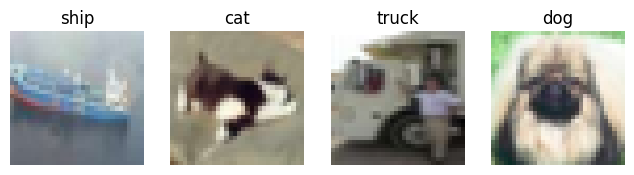

In [8]:
#function that shows images with their labels
def show_images_labels(images, labels):
    plt.figure(figsize=(10, 4))
    for i in range(4):
        plt.subplot(2, 5, i + 1)
        img = images[i] / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.title(f"{classes[labels[i]]}")
        plt.axis('off')
    plt.show()

# get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)

show_images_labels(images, labels)

---

## **CNN Architectures Used** <a id="CNN-Architectures-Used"></a>
*Details of LeNet-5 and the custom CNN model used for GA training.*


In [9]:
# Define the CNN model from Source [2] modified so it can be used for CIFAR10 dataset
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)
### End of source [2]

In [10]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10, grayscale=False):
        super(LeNet5, self).__init__()

        in_channels = 1 if grayscale else 3  # Handle grayscale vs. RGB input

        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Dynamically determine input size for the first FC layer
        self._initialize_fc_layer(in_channels, num_classes)

    def _initialize_fc_layer(self, in_channels, num_classes):
        """ Helper function to initialize the fully connected layer dynamically """
        with torch.no_grad():
            dummy_input = torch.zeros(1, in_channels, 32, 32)  # CIFAR-10 input size (3x32x32)
            dummy_output = self.features(dummy_input)
            flattened_size = dummy_output.view(1, -1).size(1)  # Flattened feature size

        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten before passing to fully connected layers
        logits = self.classifier(x)
        return logits  # Logits (no softmax, works with CrossEntropyLoss)

### Key training and testing functions.

In [11]:
def train_nn(model, trainloader, criterion, epochs=2, use_gpu=True):
    """
    Train a PyTorch neural network model efficiently.

    Args:
        model: PyTorch model to train (updated in-place).
        trainloader: DataLoader containing training data.
        criterion: Loss function.
        optimizer: Optimizer (Adam, SGD, etc.).
        epochs (int, optional): Number of training epochs. Default is 2.
        use_gpu (bool, optional): If True, enables GPU acceleration.

    Returns:
        train_losses: List of training losses over time.
        training_time: Total time taken to train the model.
    """
    # Use GPU if available and selected
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU
    optimiser = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # reinitialise the optimizer after moving to GPU


    model.train()  # Set model to training mode
    train_losses = []

    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(trainloader, start=1):
            # Move inputs and labels to the correct device (CPU/GPU)
            inputs, labels = inputs.to(device), labels.to(device)

            optimiser.zero_grad()  # Reset gradients

            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            loss.backward()  # Backpropagation
            optimiser.step()  # Update weights

            running_loss += loss.item()

            # Log loss statistics every 2000 mini-batches
            if i % 2000 == 0:
                avg_loss = running_loss / 2000
                train_losses.append(avg_loss)
                running_loss = 0.0  # Reset running loss
    end_time = time.time()

    training_time = end_time - start_time
    # print('Finished Training')
    return train_losses, training_time

In [12]:
def test_nn(testloader, model, use_gpu=True):
    """
    Efficiently tests the model on all images in the test set and returns overall accuracy.

    Args:
        testloader: PyTorch DataLoader for test data.
        model: Trained PyTorch model.
        use_gpu (bool, optional): If True, uses GPU if available. Default is True.

    Returns:
        overall_accuracy (float): Accuracy of the model on the test set.
    """
    # Select device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()  # Set model to evaluation mode

    correct = 0
    total = 0

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)  # Get predicted class

            # Update total and correct predictions
            total += labels.size(0)
            correct += (predictions == labels).sum().item()

    # Compute overall accuracy
    overall_accuracy = 100 * correct / total

    # print(f"Overall Model Accuracy: {overall_accuracy:.2f}%")
    return overall_accuracy


In [13]:
def test_4_random_images(testloader, model, classes, use_gpu=True):
    """
    Visually tests the model on 4 random images from the test set and computes approximate accuracy.

    Args:
        testloader: PyTorch DataLoader for test data.
        model: Trained PyTorch model.
        classes: List of class labels.
        use_gpu (bool, optional): Whether to use GPU if available.

    Returns:
        accuracy (float): Model accuracy on the 4 randomly selected images.
    """
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU
    model.eval()  # Set model to evaluation mode

    # Get a random batch from the testloader
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # Select 4 random indices from the batch
    indices = random.sample(range(len(images)), 4)
    selected_images = images[indices]
    selected_labels = labels[indices]

    # Move data to GPU if available
    selected_images, selected_labels = selected_images.to(device), selected_labels.to(device)

    # Get model predictions
    with torch.no_grad():
        outputs = model(selected_images)
        _, predicted = torch.max(outputs, 1)

    # Compute accuracy
    correct = (predicted == selected_labels).sum().item()
    accuracy = correct / len(selected_labels) * 100

    # Display images with labels and predictions
    show_images_labels(selected_images.cpu(), selected_labels.cpu())
    print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))
    print(f'Accuracy on these 4 images: {accuracy:.2f}%')

    return accuracy

In [14]:
def test_nn_per_class(testloader, model, classes, use_gpu=True):
    """
    Efficiently tests the model on all images in the test set and returns per-class accuracy.

    Args:
        testloader: PyTorch DataLoader for test data.
        model: Trained PyTorch model.
        classes: List of class labels.
        use_gpu (bool, optional): If True, uses GPU if available. Default is True.

    Returns:
        class_accuracies (dict): Dictionary containing accuracy for each class.
    """
    # Select device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # Prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # Disable gradient computation for efficiency
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU/CPU
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)  # Get predicted class

            # Update per-class statistics
            for label, prediction in zip(labels, predictions):
                total_pred[classes[label.item()]] += 1  # Count total instances of each class
                if label == prediction:
                    correct_pred[classes[label.item()]] += 1  # Count correct predictions

    # Compute per-class accuracy
    class_accuracies = {
        classname: (100 * correct_pred[classname] / total_pred[classname]) if total_pred[classname] > 0 else 0.0
        for classname in classes
    }

    print("Finished per-class testing.")
    return class_accuracies


---

## **Implementing Genetic Algorithm for CNN Training** <a id="Implementing-Genetic-Algorithm-for-CNN-Training"></a>
*implementation of selection, mutation, and crossover for CNN weight optimization.*

In [15]:
def compute_fitness(criterion, model, optimizer, trainloader, testloader, epochs):
    """
    Computes the fitness of a model by training and evaluating its accuracy.

    Args:
        criterion: Loss function.
        model: PyTorch model to train and evaluate.
        optimizer: Optimizer (Adam, SGD, etc.).
        trainloader: DataLoader containing training data.
        testloader: DataLoader containing test data.
        epochs (int): Number of training epochs.

    Returns:
        test_accuracy (float): Accuracy of the model on the test set.
    """
    # Train the model
    # train_nn(model, trainloader, criterion, optimizer, epochs)

    # Test the model
    test_accuracy = test_nn(testloader, model)
    return test_accuracy

In [16]:
# write a function to initialise the population
def initialise_population(population_size, model_class):
    """
    Initializes a population of models.

    Args:
        population_size (int): Number of models in the population.
        model_class (class): The class of the model to be instantiated.

    Returns:
        population (list): List of instantiated models.
    """
    population = []
    for i in range(population_size):
        model = model_class()
        population.append(model)
    return population

In [17]:
# write the function to perform the crossover operation
def crossover(parent1, parent2, use_gpu=True):
    """
    Performs crossover operation between two parent models to produce two child models.

    Args:
        parent1: First parent model (CNN or LeNet5).
        parent2: Second parent model (CNN or LeNet5).
        use_gpu (bool, optional): If True, uses GPU if available. Default is True.

    Returns:
        child1: First child model.
        child2: Second child model.
    """
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")

    if isinstance(parent1, CNN) and isinstance(parent2, CNN):
        # Initialize child models
        child1 = CNN().to(device)
        child2 = CNN().to(device)

        # Perform crossover on the convolutional layers
        child1.conv1.weight.data = torch.cat((parent1.conv1.weight.data[:16], parent2.conv1.weight.data[16:]), dim=0).to(device)
        child2.conv1.weight.data = torch.cat((parent2.conv1.weight.data[:16], parent1.conv1.weight.data[16:]), dim=0).to(device)

        # Perform crossover on the fully connected layers
        child1.fc1.weight.data = torch.cat((parent1.fc1.weight.data[:64], parent2.fc1.weight.data[64:]), dim=0).to(device)
        child2.fc1.weight.data = torch.cat((parent2.fc1.weight.data[:64], parent1.fc1.weight.data[64:]), dim=0).to(device)

    elif isinstance(parent1, LeNet5) and isinstance(parent2, LeNet5):
        # Initialize child models
        child1 = LeNet5(num_classes=10).to(device)
        child2 = LeNet5(num_classes=10).to(device)

        # Perform crossover on the convolutional layers
        child1.features[0].weight.data = torch.cat((parent1.features[0].weight.data[:3], parent2.features[0].weight.data[3:]), dim=0).to(device)
        child2.features[0].weight.data = torch.cat((parent2.features[0].weight.data[:3], parent1.features[0].weight.data[3:]), dim=0).to(device)

        # Perform crossover on the fully connected layers
        child1.classifier[0].weight.data = torch.cat((parent1.classifier[0].weight.data[:60], parent2.classifier[0].weight.data[60:]), dim=0).to(device)
        child2.classifier[0].weight.data = torch.cat((parent2.classifier[0].weight.data[:60], parent1.classifier[0].weight.data[60:]), dim=0).to(device)

    else:
        raise ValueError("Unsupported model types for crossover")

    return child1, child2

In [18]:
# write the function to perform the mutation operation
def mutate(model, mutation_rate, use_gpu=True):
    """
    Applies mutation to the model parameters by adding random noise.

    Args:
        model: PyTorch model to mutate.
        mutation_rate (float): Probability of mutation for each parameter.
        use_gpu (bool, optional): If True, uses GPU if available. Default is True.

    Returns:
        model: Mutated PyTorch model.
    """
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to GPU if available

    for param in model.parameters():
        if torch.rand(1).item() < mutation_rate:  # Check if mutation should be applied
            param.data += torch.randn(param.data.size()).to(device) * 0.1  # Add random noise to the parameter

    return model

In [19]:
def run_genetic_algorithm(model_class, criterion, population_size, generations, trainloader, testloader, epochs, mutation_rate, use_gpu=True):
    """
    Runs a Genetic Algorithm (GA) to optimize a neural network model.

    Args:
        population_size (int): Number of models in the population.
        generations (int): Number of generations to evolve.
        trainloader: PyTorch DataLoader for training data.
        testloader: PyTorch DataLoader for test data.
        epochs (int): Number of epochs for fitness evaluation.
        mutation_rate (float): Probability of mutation.

    Returns:
        results (dict): Dictionary containing:
            - 'best_model': Best model from the final generation.
            - 'generation_times': List of time taken for each generation.
            - 'best_accuracies': List of best accuracies from each generation.
    """


    # Initialize the population
    population = initialise_population(population_size, model_class)

    # Tracking metrics
    generation_times = []
    best_accuracies = []

    # Start Genetic Algorithm process
    for generation in range(generations):
        print(f"\nGeneration {generation + 1}")

        best_accuracy = 0
        best_model = None
        fitness_scores = np.zeros(population_size)  # Preallocate array for fitness scores

        # Start timer for the generation
        start_time = time.time()

        # Evaluate fitness for each model
        for i, model in enumerate(population):
            optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Define optimizer
            fitness = compute_fitness(criterion, model, optimizer, trainloader, testloader,epochs)
            fitness_scores[i] = fitness

            if fitness > best_accuracy:
                best_accuracy = fitness
                best_model = model

        # End timer for the generation
        end_time = time.time()
        generation_time = end_time - start_time

        # Store time and best accuracy for visualization
        generation_times.append(generation_time)
        best_accuracies.append(best_accuracy)

        print(f'Best accuracy in generation {generation + 1} = {best_accuracy:.4f}')
        print(f'Time taken for generation {generation + 1}: {generation_time:.2f} seconds')

        # **Parent Selection**
        top_indices = np.argsort(fitness_scores)[-population_size // 2:]  # Get top 50%
        selected_parents = [population[i] for i in top_indices]

        next_generation = []

        # **Crossover & Mutation**
        for i in range(0, len(selected_parents), 2):
            parent1 = selected_parents[i]
            parent2 = selected_parents[i + 1]

            # Perform crossover
            child1, child2 = crossover(parent1, parent2)

            # Apply mutation
            mutate(child1, mutation_rate)
            mutate(child2, mutation_rate)

            next_generation.append(child1)
            next_generation.append(child2)

        # Ensure the population size remains constant
        population = next_generation[:population_size]

    # **Return the best model and collected data for visualization**
    results = {
        "best_model": best_model,
        "generation_times": generation_times,
        "best_accuracies": best_accuracies
    }

    return results


---
## **Comparing CNNs Trained Using Genetic Algorithms** <a id="Comparing-CNNs-Trained-Using-Genetic-Algorithms"></a>
*Analyzing accuracy, training time, and performance trends across generations.*


In [20]:
#print the system stats that the models will be trained on such as the number of classes and the number of images in the training and test sets
print(f"Number of classes: {len(classes)}")
print(f"Number of training images: {len(trainloader.dataset)}")
print(f"Number of test images: {len(testloader.dataset)}")

Number of classes: 10
Number of training images: 50000
Number of test images: 10000


In [23]:
#Global variables used on all models to keep comparisions fair
#genetic algorithm parameters
GENERATIONS = 4
POPULATION_SIZE = GENERATIONS * 2
MUTATION_RATE = 0.1

#training parameters
EPOCHS = 5
USE_GPU = True
CRITERION = nn.CrossEntropyLoss()

### Base model results


In [24]:
# Initialize base models
models = {
    "Base CNN": CNN(),
    "LeNet-5": LeNet5(num_classes=10)
}

# Store results
results = {}

for model_name, model in models.items():
    # Specify the loss function and optimizer
    optimiser = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    print(f"\nEvaluating {model_name}...")
    # Train and evaluate the model storing the model
    model_results = evaluate_model(model, CRITERION, optimiser, trainloader, testloader, classes, epochs=EPOCHS, use_gpu=USE_GPU)

    # Store results
    results[model_name] = model_results

    # Print results
    accuracy = results[model_name]["final_test_accuracy"]
    training_time = results[model_name]["total_training_time"]

    print(f"{model_name} Final Accuracy: {accuracy:.2f}%")
    print(f"{model_name} Training Time: {training_time:.2f} seconds\n")


Evaluating Base CNN...
Epoch 1: Train Loss: 1.6929, Test Accuracy: 43.58%
Epoch 2: Train Loss: 1.6659, Test Accuracy: 41.09%
Epoch 3: Train Loss: 1.7115, Test Accuracy: 37.44%
Epoch 4: Train Loss: 1.6709, Test Accuracy: 42.54%


KeyboardInterrupt: 

In [ ]:
#show graphs to compare the base models

# Extracting results for plotting
cnn_losses = results["Base CNN"]["train_losses"]
lenet_losses = results["LeNet-5"]["train_losses"]

cnn_accuracy = results["Base CNN"]["final_test_accuracy"]
lenet_accuracy = results["LeNet-5"]["final_test_accuracy"]

cnn_time = results["Base CNN"]["total_training_time"]
lenet_time = results["LeNet-5"]["total_training_time"]

# Plot Training Loss Progression
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cnn_losses) + 1), cnn_losses, label="Base CNN", linestyle="-", marker="o")
plt.plot(range(1, len(lenet_losses) + 1), lenet_losses, label="LeNet-5", linestyle="--", marker="s")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss Comparison: CNN vs. LeNet-5")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training Time and Accuracy Comparison
fig, ax1 = plt.subplots(figsize=(10, 5))

# Bar chart for accuracy
ax1.bar(["Base CNN", "LeNet-5"], [cnn_accuracy, lenet_accuracy], color=['blue', 'red'], alpha=0.6, label="Accuracy")
ax1.set_ylabel("Accuracy (%)")
ax1.set_ylim(0, 100)

# Line plot for training time
ax2 = ax1.twinx()
ax2.plot(["Base CNN", "LeNet-5"], [cnn_time, lenet_time], marker="o", color="green", label="Training Time")
ax2.set_ylabel("Training Time (seconds)")

# Labels and title
plt.title("Model Comparison: Accuracy & Training Time")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.grid(True)
plt.show()

In [ ]:
#save the models after they have been trained
torch.save(models["Base CNN"].state_dict(), "base_cnn.pth")
torch.save(models["LeNet-5"].state_dict(), "lenet5.pth")

### Genetic algorithm results

In [ ]:
# Define models
models = {
    "Base CNN": CNN,
    "LeNet-5": lambda: LeNet5(num_classes=10)
}

# Store results
ga_results = {}

for model_name, model_class in models.items():
    print(f"\nRunning Genetic Algorithm for {model_name}...")

    # Run GA for this model
    ga_results[model_name] = run_genetic_algorithm(model_class, CRITERION, POPULATION_SIZE, GENERATIONS, trainloader, testloader, epochs=EPOCHS, mutation_rate=MUTATION_RATE)

In [ ]:
# Evaluate the base cnn best models
best_cnn_model = ga_results["Base CNN"]["best_model"]
best_cnn_results = evaluate_model(best_cnn_model, CRITERION, optimiser, trainloader, testloader, classes, epochs=EPOCHS, use_gpu=USE_GPU, train=False)

In [ ]:
#Evaluate the lenet best model
best_lenet_model = ga_results["LeNet-5"]["best_model"]
best_lenet_results = evaluate_model(best_lenet_model, CRITERION, optimiser, trainloader, testloader, classes, epochs=EPOCHS, use_gpu=USE_GPU, train=False)


In [ ]:
# compare the models
# Print Summary for Each Model
for model_name, results in ga_results.items():
    print(f"\n{model_name} Final Best Accuracy: {results['best_accuracies'][-1]:.2f}%")
    print(f"{model_name} Time Taken Per Generation: {results['generation_times']}")

# Extract results for visualization
cnn_best_accuracies = ga_results["Base CNN"]["best_accuracies"]
lenet_best_accuracies = ga_results["LeNet-5"]["best_accuracies"]

cnn_generation_times = ga_results["Base CNN"]["generation_times"]
lenet_generation_times = ga_results["LeNet-5"]["generation_times"]

# Plot Accuracy Progression
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cnn_best_accuracies) + 1), cnn_best_accuracies, marker="o", linestyle="-", label="Base CNN")
plt.plot(range(1, len(lenet_best_accuracies) + 1), lenet_best_accuracies, marker="s", linestyle="--", label="LeNet-5")
plt.xlabel("Generation")
plt.ylabel("Best Accuracy (%)")
plt.title("Genetic Algorithm: Accuracy Progression (CNN vs. LeNet-5)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training Time per Generation
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cnn_generation_times) + 1), cnn_generation_times, marker="o", linestyle="-", label="Base CNN")
plt.plot(range(1, len(lenet_generation_times) + 1), lenet_generation_times, marker="s", linestyle="--", label="LeNet-5")
plt.xlabel("Generation")
plt.ylabel("Time Taken (seconds)")
plt.title("Genetic Algorithm: Time Taken Per Generation (CNN vs. LeNet-5)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# save the best models
torch.save(best_cnn_model.state_dict(), "best_cnn_model.pth")
torch.save(best_lenet_model.state_dict(), "best_lenet_model.pth")

---
## **Ensemble Learning: Combining GA-Trained CNNs** <a id="Ensemble-Learning-Combining-GA-Trained-CNNs"></a>
*Applying ensemble methods like averaging, voting, and stacking to improve CNN performance.*

---

## **Evaluation and Visualization** <a id="Evaluation-and-Visualization"></a>
*Visualizing loss, accuracy trends, and decision boundaries of CNN models.*

In [ ]:
#This function will be used to evaluate the network.
def evaluate_model(model, criterion, optimiser, trainloader, testloader, classes, epochs=5, use_gpu=True, show_graph=True, train=True):
    """
    Trains and evaluates a PyTorch model while tracking losses and accuracies.

    Args:
        model: PyTorch model to train and evaluate.
        trainloader: DataLoader containing training data.
        testloader: DataLoader containing test data.
        classes: List of class labels.
        epochs (int, optional): Number of training epochs. Default is 10.
        use_gpu (bool, optional): If True, enables GPU acceleration. Default is True.
        show_graph (bool, optional): If True, displays accuracy/loss graphs. Default is True.
        train (bool, optional): If True, trains the model. Default is True.

    Returns:
        results (dict): Dictionary containing:
            - 'train_losses': List of training losses.
            - 'train_accuracies': List of training accuracies.
            - 'test_accuracies': List of test accuracies.
            - 'test_class_accuracies': Dictionary of per-class accuracy.
            - 'final_test_accuracy': Final overall test accuracy.
            - 'total_time': Total time taken for training.
    """
    # Move model to GPU if available
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    model.to(device)
    optimiser = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # reinitialise the optimizer after moving to GPU

    # Initialize tracking variables
    train_losses = []
    train_accuracies = []
    test_accuracies = []

    total_training_time = 0

    if train:
        # Training and Evaluation Loop
        for epoch in range(epochs):
            # print(f"\nEpoch {epoch+1}/{epochs}")

            # Train the model for one epoch
            train_loss, train_time = train_nn(model, trainloader, criterion, epochs=1, use_gpu=use_gpu)
            total_training_time += train_time

            # Test the model after training
            test_accuracy = test_nn(testloader, model, use_gpu=use_gpu)

            # Store losses and accuracies
            train_losses.append(train_loss[-1])  # Store the last batch loss of the epoch
            train_accuracies.append(test_nn(trainloader, model, use_gpu=use_gpu))
            test_accuracies.append(test_accuracy)

            print(f'Epoch {epoch+1}: Train Loss: {train_loss[-1]:.4f}, Test Accuracy: {test_accuracy:.2f}%')

        # Final test accuracy after all epochs
        final_test_accuracy = test_accuracies[-1]
    else:
        final_test_accuracy = test_nn(testloader, model, use_gpu=use_gpu)


    # final test acuracy per class
    test_class_accuracies = test_nn_per_class(testloader, model, classes, use_gpu=use_gpu)

    if show_graph:
        if train:
            # Plot training vs testing accuracy if enabled
            plt.figure(figsize=(12, 6))
            plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
            plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy')
            plt.title('Training vs Testing Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy (%)')
            plt.legend()
            plt.grid(True)
            plt.show()

            #plot the loss curve over time as the model trained
            plt.figure(figsize=(10, 5))
            plt.plot(train_losses, label='Training Loss', color='blue')
            plt.xlabel('Batch (x2000)')
            plt.ylabel('Loss')
            plt.title('Training Loss Over Time')
            plt.legend()
            plt.legend()
            plt.grid(True)
            plt.show()

        # Plot per-class accuracy if enabled
        plt.figure(figsize=(10, 5))
        plt.bar(test_class_accuracies.keys(), test_class_accuracies.values(), color='blue')
        plt.xlabel("Classes")
        plt.ylabel("Accuracy (%)")
        plt.title("Model Accuracy Per Class")
        plt.xticks(rotation=45)  # Rotate class names for readability
        plt.ylim(0, 100)  # Set y-axis range to 0-100%
        plt.show()

        # print per-class accuracy
        for classname, accuracy in test_class_accuracies.items():
            print(f'Accuracy for class {classname:5s}: {accuracy:.1f}%')

    # Return all results in a dictionary
    results = {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies,
        "test_class_accuracies": test_class_accuracies,
        "final_test_accuracy": final_test_accuracy,
        "total_training_time": total_training_time
    }

    return results

---
## **Conclusion** <a id="Conclusion"></a>
*Key takeaways, strengths, and future directions for GA-based CNN training.*



---
## Tutorial comparison


---
## **References** <a id="References"></a>
*Citations and references for further reading.*

source [1] : https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html <br>
source [2] : https://www.geeksforgeeks.org/how-to-implement-genetic-algorithm-using-pytorch/